In [133]:
import pandas as pd

from pathlib import Path

download_path = Path.cwd()/'UrbanSound8K'


# Read metadata file
metadata_file = download_path/'metadata'/'UrbanSound8K.csv'
#metadata_file2 = download_path/'metadata'/'UrbanSound8K_Lab.csv'

df = pd.read_csv(metadata_file)
#df2 = pd.read_csv(metadata_file2)

df.head()

# Construct file path by concatenating fold and file name
df['relative_path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)

#Take relative columns
df = df[['relative_path', 'classID']]
df.head()
data_path = str(download_path) + '/' + 'audio' + '/'
#print((df.classID==1).sum())


In [134]:
df2.classID.value_counts()

3     1000
2     1000
0     1000
9     1000
5     1000
7     1000
4     1000
8      929
1      429
6      374
11      17
10      16
Name: classID, dtype: int64

In [136]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import matplotlib
import matplotlib.pyplot as plt

class AudioUtil():
    #---------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    #---------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    #---------------
    # Convert soundfile to desired number of channels
    #---------------
    @staticmethod
    def rechannel(aud, new_channel):
        
        sig, sr = aud
        
        if sig.shape[0] == new_channel:
            #Nothing todo
            return aud
        
        if (new_channel == 1):
            #Convert stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            #Convert from mono to sterio by duplicating the first channel
            resig = torch.cat([sig,sig])
        return ((resig, sr))
    
    #---------------
    #Resample to make sure samplerate is the same for all files - resample applies to one channel at a time
    #---------------
    @staticmethod
    def resample(aud, newsr):
        
        sig, sr = aud
        
        if (sr == newsr):
            #do nothing
            return aud
        
        num_channels = sig.shape[0]
        
        #resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        
        if (num_channels > 1):
            #Resample the second channel and merge both
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
            
        return ((resig, newsr))
    
    
    #-----------------
    #Pad or turncate the signal to be off a standard length in milliseconds
    #-----------------
    @staticmethod
    def pad_trunc(aud, max_ms):

        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms
        
        if (sig_len > max_len):
            #Turncate the signal to the given length
            sig = sig[:,:max_len]
        elif (sig_len < max_len):
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            
            #pad with zeroes
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        return (sig, sr)

    #--------------------
    #Shift the signal by a random bit, end of signal is wrapped around 
    #to beginning
    #--------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    
    #----------------------------------
    #Genetate spectrogram
    #----------------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80
        
        #spec has shape [channel, n_mels, time]
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        
        #convert to db
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        return spec
    
    
    #Augment the spectrogram by masking out some sections of it in both the frequency
    #dimencion (Horizontal) and the time dimension (vertical bars)
    
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec
        
        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
        
        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
        
        return aug_spec
    
        

In [137]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

#----------------
#Sound dataset
#----------------
    
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
    
    #------------------
    #Number of items in dataset
    #------------------
    def __len__(self):
        return len(self.df)

    #------------------
    #Get i'th item in dataset
    #------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio direcory
        # with the relative path
        audio_file = self.data_path + self.df.loc[idx, 'relative_path']
        # Get the class ID
        class_id = self.df.loc[idx, 'classID']
        
        aud = AudioUtil.open(audio_file)
        #Make all the sounds have the same number of channels and same sample rate
        #Then make all samples the same length
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)
        
        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        #aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        return aug_sgram, class_id
    
    def get_aug_sgram(audio_file):
        aud = AudioUtil.open(audio_file)
        #Make all the sounds have the same number of channels and same sample rate
        #Then make all samples the same length
        reaud = AudioUtil.resample(aud, 44100)
        rechan = AudioUtil.rechannel(reaud, 2)
        
        dur_aud = AudioUtil.pad_trunc(rechan, 4000)
        shift_aud = AudioUtil.time_shift(dur_aud, 0.4)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        #aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        return aug_sgram


In [138]:
# Splitt data for training and validation

myds = SoundDS(df, data_path) #returns spectrogram and classID
#Random split between training and validation data

num_items = len(myds)
num_train = round(num_items*0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)


In [139]:
import torch.nn.functional as F
from torch.nn import init
from torch import nn

#---------------------------
# Audio Classification Model
#---------------------------
class AudioClassifier (nn.Module):
    #---------------------------
    #Build the model architecture
    #---------------------------
    
    def __init__(self):
        super().__init__()
        conv_layers = []
        
        #First convolution block with Relu and Batch Norm. Use Kaiming Initialisation
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        #Second convolution block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]
        
        #Third convolution block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        #Fourth convolution block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4] 
        
        # Linear classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=df.classID.max()+1) #Changed Jonas out_features
        
        # Wrap the convolutional blocks
        self.conv = nn.Sequential(*conv_layers)
    
    #-------------------------
    #Forward pass computations
    #-------------------------
    def forward(self, x):
        # Run convolutional blocks
        x = self.conv(x)
        
        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        
        # Linear layer
        x = self.lin(x)
        
        # Final output
        
        return x

# Create the model and put it on the GPU if available
myModel =  AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
#Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [140]:
#-------------------
#Training loop
#-------------------
def training(model, train_dl, num_epochs):
    #Loss function optimiser and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=0.001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')
    
    #Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        #repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            
            #Normalise the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            #Zero prameter gradients
            optimiser.zero_grad()
            
            #Forward + backward + optimise
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            scheduler.step()
            
            #Keep stats for Loss and Accuracy
            running_loss += loss.item()
            
            
            #Get predicted class with highest score
            _, prediction = torch.max(outputs, 1)
            # Count the predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
            if i % 10 == 0: #
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
        
        #Print stats at the end of each epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    
    print('Finished Training')
    
num_epochs = 2
training(myModel, train_dl, num_epochs)
    

[1,     1] loss: 0.241
[1,    11] loss: 2.576
[1,    21] loss: 4.900
[1,    31] loss: 7.181
[1,    41] loss: 9.411
[1,    51] loss: 11.670
[1,    61] loss: 13.849
[1,    71] loss: 16.000
[1,    81] loss: 18.097
[1,    91] loss: 20.146
[1,   101] loss: 22.283
[1,   111] loss: 24.365
[1,   121] loss: 26.342
[1,   131] loss: 28.397
[1,   141] loss: 30.400
[1,   151] loss: 32.325
[1,   161] loss: 34.317
[1,   171] loss: 36.333
[1,   181] loss: 38.287
[1,   191] loss: 40.202
[1,   201] loss: 42.127
[1,   211] loss: 43.989
[1,   221] loss: 45.878
[1,   231] loss: 47.818
[1,   241] loss: 49.632
[1,   251] loss: 51.462
[1,   261] loss: 53.199
[1,   271] loss: 54.992
[1,   281] loss: 56.777
[1,   291] loss: 58.580
[1,   301] loss: 60.393
[1,   311] loss: 62.094
[1,   321] loss: 63.762
[1,   331] loss: 65.670
[1,   341] loss: 67.492
[1,   351] loss: 69.207
[1,   361] loss: 70.955
[1,   371] loss: 72.703
[1,   381] loss: 74.464
[1,   391] loss: 76.197
[1,   401] loss: 77.873
[1,   411] loss: 79.6

In [141]:
#-------------------
#Inferrence
#-------------------

def inferrence (model, val_dl):
    correct_prediction = 0
    total_prediction = 0
    
    #Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            #Normalise the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            #Get predictions
            outputs = model(inputs)
            
            
            #Get predicted putputs with highest score
            _, prediction = torch.max(outputs,1)
            #Count of predictions that matched target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
    acc = correct_prediction / total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

def inferrence_single (model, data):
    with torch.no_grad():
        data = data.unsqueeze(0)
        input_data = data.to(device)
        #Normalize inputs
        input_data_m, input_data_std = input_data.mean(), input_data.std()
        input_data = (input_data - input_data_m) / input_data_std
        
        #Get predictions
        output = model(input_data)
        
        #Get predicted outputs with highest score
        i, prediction = torch.max(output,1)
        
        print("Prediction for file: {}{}".format(i,prediction.item()))
        
        




#Run inferrence on trained model with validation set
inferrence(myModel, val_dl)

#Run inferrence on single recording
#sgram = SoundDS.get_aug_sgram('24_lesker_normal.wav') #returns spectrogram

#inferrence_single(myModel, sgram)

Accuracy: 0.50, Total items: 1746


In [65]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show()


In [26]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

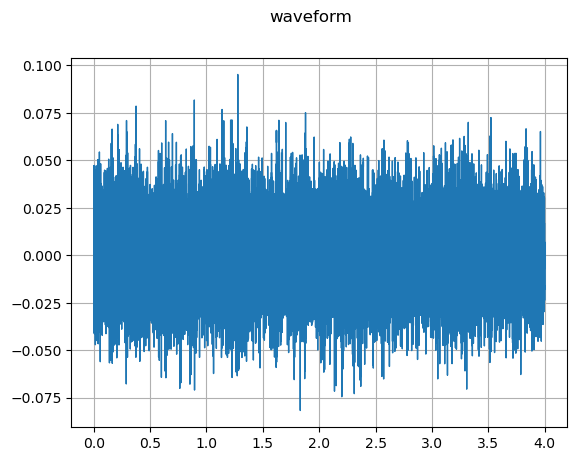

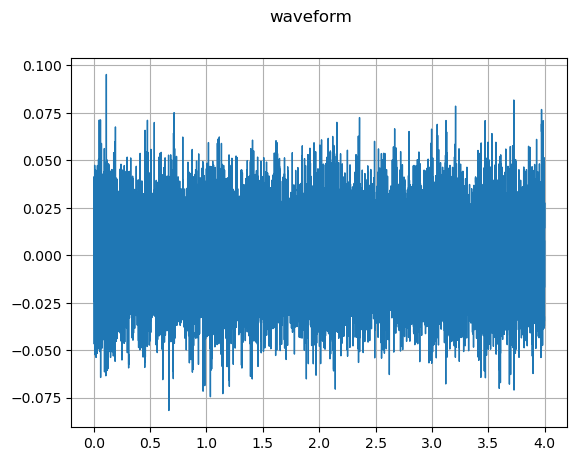

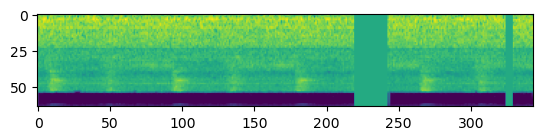

In [33]:
d = AudioUtil()
#aud = d.open('UrbanSound8K/audio/' + df.relative_path[1])
aud = d.open('12_lesker_normal.wav')

signl = d.rechannel(aud, 1)
resampled = d.resample(signl, 44000)
pad_sig = d.pad_trunc(resampled, 4000)
shifted_sig = d.time_shift(pad_sig, 500)
sig, sr = pad_sig
sig2, sr2 = shifted_sig
plot_waveform(sig, sr)
plot_waveform(sig2,sr2)
spec = d.spectro_gram(shifted_sig)
#print("Shape of spectrogram: {}".format(spec.size()))
spec_aug = d.spectro_augment(spec)
plt.figure()
plt.imshow(spec_aug[0,:,:].numpy())


In [32]:
from IPython.display import Audio

Audio(sig.numpy()[0], rate=sr)


In [114]:
from pydub import AudioSegment
import re
directory = "LabSounds"
file_name = "lesker_system_normal.wav"
import_file = directory + "/" + file_name
name,ftype = file_name.split('.')
if ftype != 'wav':
    import_file = directory + "/" + name + '.wav'
    file_handle = track.export(import_file, format='wav')
    print("File converted to:{}".format(ftype))


In [3]:
from pydub import AudioSegment
import pandas as pd

#Each file should have the format matching the example ie
#100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark

#slice_file_name,   fsID,   start, end,       salience, fold, classID, class
#100032-3-0-0.wav,  100032, 0.0,   0.317551,  1,        5,    3,       dog_bark
#1000000-11-0-0.wav 1000000 0.0,   0.0        0,        11,   11,      lesker_normal

def split_recording(track, fsid, class_name, classID, directory, metadata, split_length=4, fold_numb=11):
    length = int(track.duration_seconds)
    fold = directory + 'fold' + str(fold_numb) + '/'

    for i in range(0, length, split_length):
        fsid = fsid + i
        #[fsID]-[classID]-[occurrenceID]-[sliceID].wav
        split_fn = str(fsid) + '-' + str(classID) + '-0-0.wav'
        #slice_file_name,fsID,start,end,salience,fold,classID,class
        csv_entry = {
            'slice_file_name' : [str(split_fn)],
            'fsID' : [fsid],
            'start': [0.0],
            'end' : [0.0],
            'salience' : [0],
            'fold' : [fold_numb],
            'classID' : [sound_class],
            'class' : [class_name]
        }
        df = pd.DataFrame(csv_entry)
        df.to_csv(metadata, mode='a', index=False, header=False)

        split_strt = i * 1000
        split_end = i * 1000 + split_length * 1000
        split_audio = track[split_strt: split_end]
        split_audio.export(fold+split_fn, format='wav')

directory = 'UrbanSound8K/audio/'
metadata = 'UrbanSound8K/metadata/UrbanSound8K_Lab.csv'
import_file = 'home_sounds/dehumidifier.wav'
track = AudioSegment.from_file(import_file)

fsid = 2000000
file_name = 'dehumidifier'
sound_class = 11
split_recording(track, fsid, file_name, sound_class, directory, metadata)

In [31]:
#Each .wav file recording should be splitt into a training part and a verification part

SoundDS.test('Hello!')


Hello!
